# Simple sorter on generated dataset

In this quick demp, we will simulate 5 minutes of a very simple dataset one a tetrode with 5 units only.

We will run a very "simple" sorter on it, which mimics the "old" way of doing spike sorting.
The simple sorter runs the following steps:
  1. preprocess signal
  2. detect peaks with a threshold
  3. extract waveforms snippets
  4. dimensionality reduction of waveforms using SVD (aka PCA)
  5. try some clustering algorithms on the projected waveforms:
     * HDBSCAN
     * KMeans
     * MeanShift
     * ...

This demo should demonstrate how easy it is to setup a simple spike sorting pipeline, **BUT* also the drawback and limits of this apprach without template matching.


In [1]:
# this is for debuging
%matplotlib inline

Let's start with imports:

In [2]:
from pathlib import Path
import shutil

import numpy as np

import matplotlib.pyplot as plt

import spikeinterface.full as si

In [3]:
# the path where we want to run the spike sorting
base_folder = Path("/home/samuel/DataSpikeSorting/Edinburgh_SI_tutorials/generated_recording/")

In [4]:
si.set_global_job_kwargs(n_jobs=-1, progress_bar=True, chunk_duration="1s")

## Generate data

`spikeinterface` has a range of tools (from simple to more sophisticated) to generate "fake" datasets with ground-truth (aka known spiking activity) for testing purposes. 

Here, we simulated a simple recording of 5 minutes with 5 units on a tetrode (4 channels):

In [5]:
recording, drifting_recording, gt_sorting = si.generate_drifting_recording(
    num_units=5,
    duration=300.,
    generate_probe_kwargs=dict(
        num_columns=2,
        num_contact_per_column=[2, 2],
        xpitch=20,
        ypitch=20,
        contact_shapes="square",
        contact_shape_params={"width": 12},
    ),
    generate_templates_kwargs=dict(
        ms_before=1.5,
        ms_after=3.0,
        mode="ellipsoid",
        unit_params=dict(
            alpha=(150.0, 500.0),
            spatial_decay=(10, 40),
        ),
    ),
    generate_unit_locations_kwargs=dict(
        margin_um=10.0,
        minimum_z=6.0,
        maximum_z=25.0,
        minimum_distance=18.0,
        max_iteration=100,
        distance_strict=False,
    ),    
    generate_sorting_kwargs=dict(firing_rates=(2.0, 5.0), refractory_period_ms=4.0),
    generate_noise_kwargs=dict(noise_levels=(12.0, 15.0), spatial_decay=25.0),
    seed=2205
)

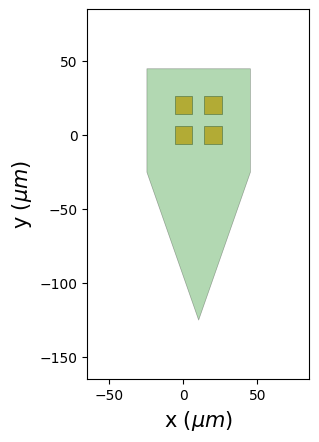

In [6]:
si.plot_probe_map(recording)

In [7]:
si.plot_traces(recording, backend="ephyviewer")

### Run a sorter



In [8]:
sorter_folder = base_folder / "static_simple_sorter"
if sorter_folder.exists():
    shutil.rmtree(sorter_folder)

sorter_params = dict(
    apply_preprocessing=True,
    # apply_preprocessing=False,
    waveforms=dict(ms_before=1.0, ms_after=1.8),
    filtering=dict(freq_min=300, freq_max=8000.0),
    detection=dict(peak_sign="neg", detect_threshold=5., exclude_sweep_ms=0.4, radius_um=100),
    features=dict(n_components=3),
    clustering=dict(method="hdbscan"),
    # clustering=dict(method="kmeans", n_clusters=3),
    # clustering=dict(method="gaussian_mixture", n_components=5),
    # clustering=dict(method="mean_shift", bin_seeding=True),
    # clustering=dict(method="affinity_propagation"),
    job_kwargs=dict(n_jobs=-1),
)
sorting = si.run_sorter("simple", recording, folder=sorter_folder, verbose=True, **sorter_params)
print(sorting)

detect peaks using locally_exclusive:   0%|          | 0/300 [00:00<?, ?it/s]

We found 3690 peaks in total


extract waveforms shared_memory mono buffer:   0%|          | 0/300 [00:00<?, ?it/s]

extracting features:   0%|          | 0/300 [00:00<?, ?it/s]

simple run time 9.94s
NumpyFolder: 7 units - 1 segments - 30.0kHz


### Let's explore some waveforms "features"

Our "simple_sorter" produces some output files we can explore after the `run_sorter(...)` function.

The file `features_tsvd.npy` contains the features computed by our sorter.
The file `peak_labels.npy` contains the labels set by our sorter.

The shape of the `features_tsvd` is `(num_spikes, num_components, num_channels)`.
These features can be flattened (make them a 1D array) and then visualized with tools like `UMAP`.

In [9]:
features = np.load(sorter_folder / "sorter_output/features/features_tsvd.npy")
features_flat = features.reshape(features.shape[0], -1)

peak_labels = np.load(sorter_folder / "sorter_output/features/peak_labels.npy")
print(features.shape, features_flat.shape,  peak_labels.shape,features.dtype)

(3690, 3, 4) (3690, 12) (3690,) float32


/home/samuel/.venvs/py3.12/lib/python3.12/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/home/samuel/.venvs/py3.12/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/samuel/.venvs/py3.12/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors

UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})


<Axes: >

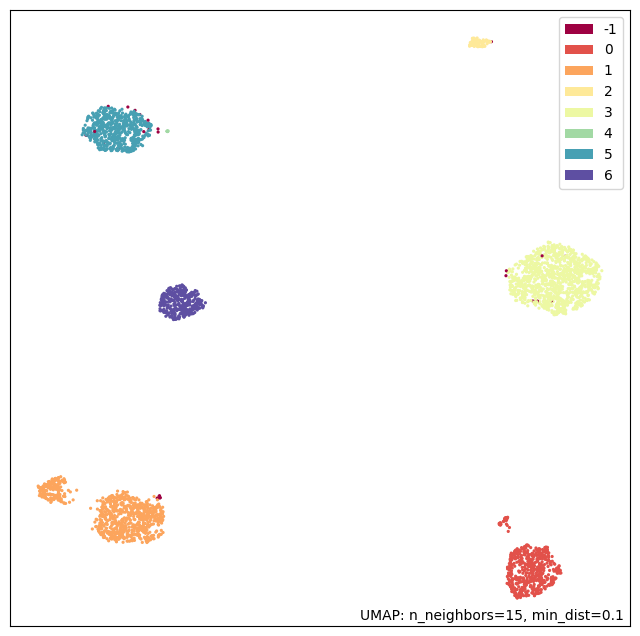

In [10]:
import umap
import umap.plot

mapper = umap.UMAP().fit(features_flat)
print(mapper)
umap.plot.points(mapper, labels=peak_labels)

We can see that the `HDBSCAN` clustering method used by the "simple sorter" is in agreement with the `UMAP` dimensionality reduction.

## SortingAnalyzer

We can now construct a `SortingAnalyzer` using the `recording` and `sorting` objects and explore the results with the `spikeinterface-gui`.

In [11]:
analyzer = si.create_sorting_analyzer(sorting, recording, sparse=False)
analyzer.compute(["random_spikes", "waveforms", "templates", "noise_levels"])
analyzer.compute(["spike_amplitudes", "unit_locations", "principal_components", "correlograms", "template_similarity"])
analyzer.compute("quality_metrics", metric_names=["snr", "amplitude_cutoff", "rp_violation"])
analyzer

compute_waveforms:   0%|          | 0/300 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/7 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/7 [00:00<?, ?it/s]

Compute : spike_amplitudes:   0%|          | 0/300 [00:00<?, ?it/s]

/home/samuel/Documents/SpikeInterface/spikeinterface/src/spikeinterface/qualitymetrics/misc_metrics.py:908: UserWarning: Some units have too few spikes : amplitude_cutoff is set to NaN
  warnings.warn(f"Some units have too few spikes : amplitude_cutoff is set to NaN")


SortingAnalyzer: 4 channels - 7 units - 1 segments - memory - has recording
Loaded 10 extensions: random_spikes, waveforms, templates, noise_levels, unit_locations, principal_components, correlograms, template_similarity, spike_amplitudes, quality_metrics

In [12]:
%gui qt
si.plot_sorting_summary(analyzer, backend="spikeinterface_gui")

We can observe that 2 units should be merged!

## SortingAnalyzer on the ground-truth

In [13]:
gt_analyzer = si.create_sorting_analyzer(gt_sorting, recording, sparse=False)
gt_analyzer.compute(["random_spikes", "waveforms", "templates", "noise_levels"])
gt_analyzer.compute(["spike_amplitudes", "unit_locations", "principal_components", "correlograms", "template_similarity"])
gt_analyzer.compute("quality_metrics", metric_names=["snr", "amplitude_cutoff", "rp_violation"])
gt_analyzer

compute_waveforms:   0%|          | 0/300 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/5 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/5 [00:00<?, ?it/s]

Compute : spike_amplitudes:   0%|          | 0/300 [00:00<?, ?it/s]

SortingAnalyzer: 4 channels - 5 units - 1 segments - memory - has recording
Loaded 10 extensions: random_spikes, waveforms, templates, noise_levels, unit_locations, principal_components, correlograms, template_similarity, spike_amplitudes, quality_metrics

In [14]:
si.plot_sorting_summary(gt_analyzer, backend="spikeinterface_gui")

## Comparison with ground truth

`spikeinterface` has a simple way check the result of a sorter and benchmark it against the ground-truth sorting.

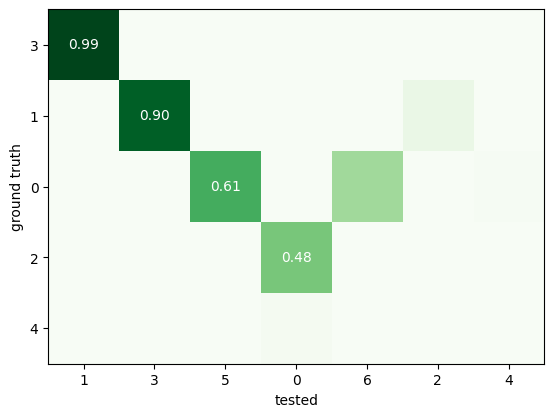

In [15]:
comp = si.compare_sorter_to_ground_truth(gt_sorting, sorting)
si.plot_agreement_matrix(comp)

## Curation with quality metrics

We can try to automatically "clean" the sorting results with quality metrics:

In [16]:
metrics = analyzer.get_extension("quality_metrics").get_data()
metrics

,snr,amplitude_cutoff,rp_contamination,rp_violations
0,4.317581,0.013472,0,0
1,7.84364,0.003071,0,0
2,16.739906,<NA>,0,0
3,17.275619,0.003488,0,0
4,15.552909,<NA>,0,0
5,16.204522,0.007807,0,0
6,16.213657,<NA>,0,0


In [17]:
keep = metrics.query("rp_contamination < 0.25 & snr > 7")
display(keep)

keep_unit_ids = keep.index.values
print(keep_unit_ids)


,snr,amplitude_cutoff,rp_contamination,rp_violations
1,7.84364,0.003071,0,0
2,16.739906,<NA>,0,0
3,17.275619,0.003488,0,0
4,15.552909,<NA>,0,0
5,16.204522,0.007807,0,0
6,16.213657,<NA>,0,0


[1 2 3 4 5 6]


In [20]:
analyzer_clean = analyzer.select_units(unit_ids=keep_unit_ids)
analyzer_clean

SortingAnalyzer: 4 channels - 6 units - 1 segments - memory - has recording
Loaded 10 extensions: random_spikes, waveforms, templates, noise_levels, unit_locations, principal_components, correlograms, template_similarity, spike_amplitudes, quality_metrics

In [21]:
%gui qt
si.plot_sorting_summary(analyzer_clean, backend="spikeinterface_gui")

## Compare curated sorting with the ground truth

Here we compare the cleaned sorting output against ground truth:

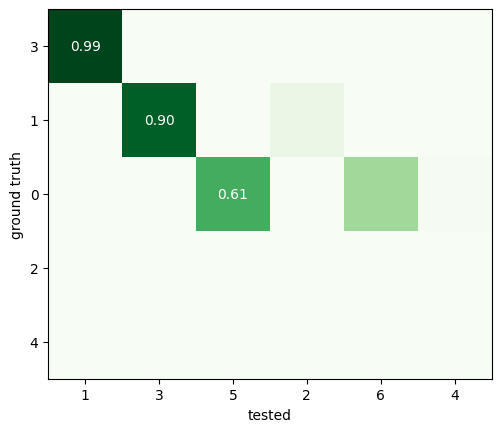

In [22]:
comp_clean = si.compare_sorter_to_ground_truth(gt_sorting, analyzer_clean.sorting)
si.plot_agreement_matrix(comp_clean)

## More difficult: the drift!

So far, we have analyzed a "static" recording. What happens when we add some drift?

In [23]:
gt_drift_analyzer = si.create_sorting_analyzer(gt_sorting, drifting_recording, sparse=False)
gt_drift_analyzer.compute(["random_spikes", "waveforms", "templates", "noise_levels"])
gt_drift_analyzer.compute(["spike_amplitudes", "unit_locations", "principal_components", "correlograms", "template_similarity"])
gt_drift_analyzer.compute("quality_metrics", metric_names=["snr", "amplitude_cutoff", "rp_violation"])
gt_drift_analyzer

compute_waveforms:   0%|          | 0/300 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/5 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/5 [00:00<?, ?it/s]

Compute : spike_amplitudes:   0%|          | 0/300 [00:00<?, ?it/s]

SortingAnalyzer: 4 channels - 5 units - 1 segments - memory - has recording
Loaded 10 extensions: random_spikes, waveforms, templates, noise_levels, unit_locations, principal_components, correlograms, template_similarity, spike_amplitudes, quality_metrics

In [24]:
%gui qt
si.plot_sorting_summary(gt_drift_analyzer, backend="spikeinterface_gui")

In [26]:
sorter_folder = base_folder / "drifting_simple_sorter"
if sorter_folder.exists():
    shutil.rmtree(sorter_folder)

sorter_params = dict(
    apply_preprocessing=True,
    # apply_preprocessing=False,
    waveforms=dict(ms_before=1.0, ms_after=1.8),
    filtering=dict(freq_min=300, freq_max=8000.0),
    detection=dict(peak_sign="neg", detect_threshold=5., exclude_sweep_ms=0.4, radius_um=100),
    features=dict(n_components=3),
    clustering=dict(method="hdbscan"),
    # clustering=dict(method="kmeans", n_clusters=3),
    # clustering=dict(method="gaussian_mixture", n_components=5),
    # clustering=dict(method="mean_shift", bin_seeding=True),
    # clustering=dict(method="affinity_propagation"),
    job_kwargs=dict(n_jobs=-1),
)
sorting_drift = si.run_sorter("simple", drifting_recording, folder=sorter_folder, verbose=True, **sorter_params)
print(sorting_drift)

detect peaks using locally_exclusive:   0%|          | 0/300 [00:00<?, ?it/s]

We found 2947 peaks in total


extract waveforms shared_memory mono buffer:   0%|          | 0/300 [00:00<?, ?it/s]

extracting features:   0%|          | 0/300 [00:00<?, ?it/s]

simple run time 7.36s
NumpyFolder: 2 units - 1 segments - 30.0kHz


In [27]:
drift_analyzer = si.create_sorting_analyzer(sorting_drift, drifting_recording, sparse=False)
drift_analyzer.compute(["random_spikes", "waveforms", "templates", "noise_levels"])
drift_analyzer.compute(["spike_amplitudes", "unit_locations", "principal_components", "correlograms", "template_similarity"])
drift_analyzer.compute("quality_metrics", metric_names=["snr", "amplitude_cutoff", "rp_violation"])
drift_analyzer

compute_waveforms:   0%|          | 0/300 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/2 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/2 [00:00<?, ?it/s]

Compute : spike_amplitudes:   0%|          | 0/300 [00:00<?, ?it/s]

SortingAnalyzer: 4 channels - 2 units - 1 segments - memory - has recording
Loaded 10 extensions: random_spikes, waveforms, templates, noise_levels, unit_locations, principal_components, correlograms, template_similarity, spike_amplitudes, quality_metrics

In [28]:
%gui qt
si.plot_sorting_summary(drift_analyzer, backend="spikeinterface_gui")

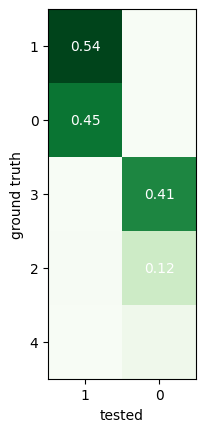

In [29]:
comp_drift = si.compare_sorter_to_ground_truth(gt_sorting, sorting_drift)
si.plot_agreement_matrix(comp_drift)

Drift makes things much more complicated! For long probes, like Neuropixels and other silicon probes, several drift correction methods can be applied as a preprocessing step to improve spike sorting performance.


To conclude, even for simple cases spike sorting can be tricky! In the next tutorial, we will see an overview application of `spikeinterface` on a real-world example.